# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [3]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [4]:
from unityagents import UnityEnvironment
# You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [7]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [8]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size*2, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size*2, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+(action_size*2), fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [9]:
import numpy as np
import random
import copy
from collections import namedtuple, deque


import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
LEARN_EVERY = 1         # learning timestep interval
LEARN_NUM = 5           # number of learning passes
GAMMA = 0.99            # discount factor
TAU = 8e-3              # for soft update of target parameters
OU_SIGMA = 0.2          # Ornstein-Uhlenbeck noise parameter, volatility
OU_THETA = 0.15         # Ornstein-Uhlenbeck noise parameter, speed of mean reversion
EPS_START = 5.0         # initial value for epsilon in noise decay process in Agent.act()
EPS_EP_END = 300        # episode to end the noise decay process
EPS_FINAL = 0           # final value for epsilon after decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent():
    def __init__(self, state_size, action_size, num_agents, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)
        self.eps = EPS_START
        self.eps_decay = 1/(EPS_EP_END*LEARN_NUM)  # set decay rate based on epsilon end target
        self.timestep = 0

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise((num_agents, action_size), random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, state, action, reward, next_state, done, agent_number):
        self.timestep += 1
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)
        # Learn, if enough samples are available in memory and at learning interval settings
        if len(self.memory) > BATCH_SIZE and self.timestep % LEARN_EVERY == 0:
                for _ in range(LEARN_NUM):
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA, agent_number)

    def act(self, states, add_noise):
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((self.num_agents, self.action_size))
        self.actor_local.eval()
        with torch.no_grad():
            # get action for each agent and concatenate them
            for agent_num, state in enumerate(states):
                action = self.actor_local(state).cpu().data.numpy()
                actions[agent_num, :] = action
        self.actor_local.train()
        # add noise to actions
        if add_noise:
            actions += self.eps * self.noise.sample()
        actions = np.clip(actions, -1, 1)
        return actions

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma, agent_number):
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        # Construct next actions vector relative to the agent
        if agent_number == 0:
            actions_next = torch.cat((actions_next, actions[:,2:]), dim=1)
        else:
            actions_next = torch.cat((actions[:,:2], actions_next), dim=1)
        # Compute Q targets for current states (y_i)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        # Construct action prediction vector relative to each agent
        if agent_number == 0:
            actions_pred = torch.cat((actions_pred, actions[:,2:]), dim=1)
        else:
            actions_pred = torch.cat((actions[:,:2], actions_pred), dim=1)
        # Compute actor loss
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

        # update noise decay parameter
        self.eps -= self.eps_decay
        self.eps = max(self.eps, EPS_FINAL)
        self.noise.reset()

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:

    def __init__(self, size, seed, mu=0.0, theta=OU_THETA, sigma=OU_SIGMA):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [10]:
SOLVED_SCORE = 2.7
CONSEC_EPISODES = 100
PRINT_EVERY = 10
ADD_NOISE = True


def maddpg(n_episodes=6000, max_t=1000, train_mode=True):
    scores_window = deque(maxlen=CONSEC_EPISODES)
    scores_all = []
    moving_average = []
    best_score = -np.inf
    best_episode = 0
    already_solved = False    

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]         # reset the environment
        states = np.reshape(env_info.vector_observations, (1,48)) # get states and combine them
        agent_0.reset()
        agent_1.reset()
        scores = np.zeros(num_agents)
        while True:
            actions = get_actions(states, ADD_NOISE)           # choose agent actions and combine them
            env_info = env.step(actions)[brain_name]           # send both agents' actions together to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the agent next states
            rewards = env_info.rewards                         # get reward
            done = env_info.local_done                         # see if episode finished
            agent_0.step(states, actions, rewards[0], next_states, done, 0) # agent 1 learns
            agent_1.step(states, actions, rewards[1], next_states, done, 1) # agent 2 learns
            scores += np.max(rewards)                          # update the score for each agent
            states = next_states                               # roll over states to next time step
            if np.any(done):                                   # exit loop if episode finished
                break

        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        moving_average.append(np.mean(scores_window))

        # save best score                        
        if ep_best_score > best_score:
            best_score = ep_best_score
            best_episode = i_episode
        
#         if (i_episode > 1000 and np.mean(scores_window) <0.08):
#             break
        
        # print results
        if i_episode % 10 == 0:
            print('\rEpisodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode-PRINT_EVERY, i_episode, np.max(scores_all[-PRINT_EVERY:]), moving_average[-1]))
#             torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
#             torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
#             torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
#             torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
        
        if i_episode % 100 == 0:
            print('\r\nEpisodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f} \n Saved!!!\n'.format(
                i_episode-PRINT_EVERY, i_episode, np.max(scores_all[-PRINT_EVERY:]), moving_average[-1]))
            torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
            torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
            torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
        
        # determine if environment is solved and keep best performing models
        if moving_average[-1] >= 2.5:
            if not already_solved:
                print('\r<-- Environment solved in {:d} episodes! \
                \n<-- Moving Average: {:.3f} over past {:d} episodes'.format(
                    i_episode-CONSEC_EPISODES, moving_average[-1], CONSEC_EPISODES))
                already_solved = True
                # save weights
                torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
                torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
                torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
            elif ep_best_score >= best_score:
                print('\r<-- Best episode so far!\
                \nEpisode {:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode, ep_best_score, moving_average[-1]))
                # save weights
                torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
                torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
                torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
            elif (moving_average[-1]) >= 2.5:
                # stop training if model stops converging
#                 print('<-- Training stopped. Best score not matched or exceeded for 200 episodes')
                break
            else:
                continue
            
    return scores_all, moving_average

def get_actions(states, add_noise):
    '''gets actions for each agent and then combines them into one array'''
    action_0 = agent_0.act(states, add_noise)    # agent 0 chooses an action
    action_1 = agent_1.act(states, add_noise)    # agent 1 chooses an action
    return np.concatenate((action_0, action_1), axis=0).flatten()


In [11]:
# initialize agents
agent_0 = Agent(state_size, action_size, num_agents=1, random_seed=0)
agent_1 = Agent(state_size, action_size, num_agents=1, random_seed=0)

# load the weights from file
# agent_0_weights = 'checkpoint_actor_0.pth'
# agent_1_weights = 'checkpoint_actor_1.pth'
# agent_0.actor_local.load_state_dict(torch.load(agent_0_weights))
# agent_1.actor_local.load_state_dict(torch.load(agent_1_weights))
  
# run the training loop

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
LR_ACTOR = 1e-4         # learning rate of the actor
LR_CRITIC = 2e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
LEARN_EVERY = 1         # learning timestep interval
LEARN_NUM = 1           # number of learning passes
GAMMA = 0.99            # discount factor
TAU = 7e-2              # for soft update of target parameters
OU_SIGMA = 0.2          # Ornstein-Uhlenbeck noise parameter, volatility
OU_THETA = 0.12         # Ornstein-Uhlenbeck noise parameter, speed of mean reversion
EPS_START = 5.5                 # initial value for epsilon in noise decay process in Agent.act()
EPS_EP_END = 250        # episode to end the noise decay process
EPS_FINAL = 0           # final value for epsilon after decay

scores, avgs = maddpg()  

Episodes 0000-0010	Max Reward: 0.500	Moving Average: 0.060
Episodes 0010-0020	Max Reward: 0.000	Moving Average: 0.030
Episodes 0020-0030	Max Reward: 0.000	Moving Average: 0.020
Episodes 0030-0040	Max Reward: 0.000	Moving Average: 0.015
Episodes 0040-0050	Max Reward: 0.000	Moving Average: 0.012
Episodes 0050-0060	Max Reward: 0.000	Moving Average: 0.010
Episodes 0060-0070	Max Reward: 0.000	Moving Average: 0.009
Episodes 0070-0080	Max Reward: 0.000	Moving Average: 0.008
Episodes 0080-0090	Max Reward: 0.000	Moving Average: 0.007
Episodes 0090-0100	Max Reward: 0.100	Moving Average: 0.007

Episodes 0090-0100	Max Reward: 0.100	Moving Average: 0.007 
 Saved!!!

Episodes 0100-0110	Max Reward: 0.000	Moving Average: 0.001
Episodes 0110-0120	Max Reward: 0.000	Moving Average: 0.001
Episodes 0120-0130	Max Reward: 0.100	Moving Average: 0.002
Episodes 0130-0140	Max Reward: 0.100	Moving Average: 0.003
Episodes 0140-0150	Max Reward: 0.100	Moving Average: 0.006
Episodes 0150-0160	Max Reward: 0.300	Moving

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


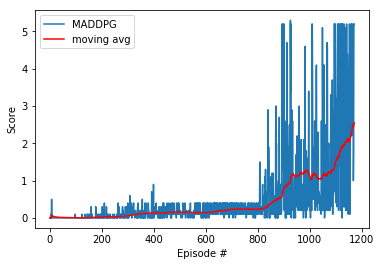

In [13]:
# plot the scores                                                                                                                                                         
from collections import deque               
import matplotlib.pyplot as plt                                  
import numpy as np                                                                                    
import random                                                                     
import time                      
import torch   
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
fig.show()
fig.savefig("MADDPG_1e04__3000.png")


In [12]:
## reinitialize the agents (if needed)
agent_0 = Agent(state_size, action_size, num_agents=1, random_seed=0)
agent_1 = Agent(state_size, action_size, num_agents=1, random_seed=0)

# load the weights from file
agent_0_weights = 'checkpoint_actor_0.pth'   
agent_1_weights = 'checkpoint_actor_1.pth'
agent_0.actor_local.load_state_dict(torch.load(agent_0_weights))
agent_1.actor_local.load_state_dict(torch.load(agent_1_weights))

In [14]:
CONSEC_EPISODES = 50
PRINT_EVERY = 1
ADD_NOISE = False

def test(n_episodes=100, max_t=1000, train_mode=False):

    scores_window = deque(maxlen=CONSEC_EPISODES)
    scores_all = []
    moving_average = []  

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]         # reset the environment
        states = np.reshape(env_info.vector_observations, (1,48)) # get states and combine them
        scores = np.zeros(num_agents)
        while True:
            actions = get_actions(states, ADD_NOISE)           # choose agent actions and combine them
            env_info = env.step(actions)[brain_name]           # send both agents' actions together to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the agent next states
            rewards = env_info.rewards                         # get reward
            done = env_info.local_done                         # see if episode finished
            scores += np.max(rewards)                          # update the score for each agent
            states = next_states                               # roll over states to next time step
            if np.any(done):                                   # exit loop if episode finished
                break

        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        moving_average.append(np.mean(scores_window))

        # print results
        if i_episode % PRINT_EVERY == 0:
            print('Episodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode-PRINT_EVERY, i_episode, np.max(scores_all[-PRINT_EVERY:]), moving_average[-1]))
            
    return scores_all, moving_average

Episodes 0000-0001	Max Reward: 3.490	Moving Average: 3.490
Episodes 0001-0002	Max Reward: 5.200	Moving Average: 4.345
Episodes 0002-0003	Max Reward: 0.600	Moving Average: 3.097
Episodes 0003-0004	Max Reward: 5.200	Moving Average: 3.623
Episodes 0004-0005	Max Reward: 5.200	Moving Average: 3.938
Episodes 0005-0006	Max Reward: 4.500	Moving Average: 4.032
Episodes 0006-0007	Max Reward: 5.100	Moving Average: 4.184
Episodes 0007-0008	Max Reward: 0.100	Moving Average: 3.674
Episodes 0008-0009	Max Reward: 1.400	Moving Average: 3.421
Episodes 0009-0010	Max Reward: 5.100	Moving Average: 3.589
Episodes 0010-0011	Max Reward: 0.100	Moving Average: 3.272
Episodes 0011-0012	Max Reward: 5.200	Moving Average: 3.433
Episodes 0012-0013	Max Reward: 5.200	Moving Average: 3.568
Episodes 0013-0014	Max Reward: 0.300	Moving Average: 3.335
Episodes 0014-0015	Max Reward: 5.100	Moving Average: 3.453
Episodes 0015-0016	Max Reward: 5.200	Moving Average: 3.562
Episodes 0016-0017	Max Reward: 0.300	Moving Average: 3.3

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


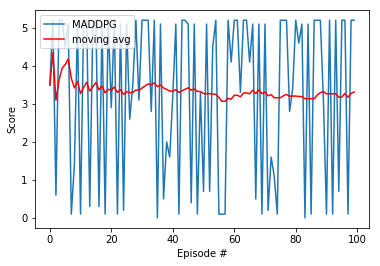

In [15]:
scores, avgs = test()

# plot the scores
from collections import deque
import matplotlib.pyplot as plt           
import numpy as np
import random
import time
import torch
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg')
plt.ylabel('Score') 
plt.xlabel('Episode #')
plt.legend(loc='upper left');
fig.savefig("MADDPG_Test2.png")
fig.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


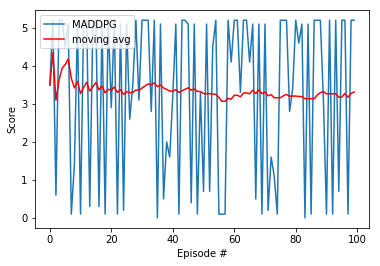

In [16]:
fig = plt.figure()                            
ax = fig.add_subplot(111) 
plt.plot(np.arange(len(scores)), scores, label='MADDPG')      
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg')
plt.ylabel('Score')    
plt.xlabel('Episode #')  
plt.legend(loc='upper left')     
fig.savefig("MADDPG_Test2.png")
fig.show()

In [17]:
#PERFORMANCE iMPROVEMENT
# LEARNING RATE WITH 1E-5 OR LESS
# KEEPING LEARING RATE DIFFERENT BETWEEN 2 AGENTS 
# INCREASE EPOCHS 
# DENSE NETWORK